# Project report

# organization of code: 

    - The code is implemented in two seprate classes, LatentDirichletAllocation class
    and GLM class for LDA implementation and logistic regression implementation, respectively. 
    - These two implementation has been segmented into two parts namely, "LDA Implementation" 
    and  "logistic regression implementation".
    - After the two classes implemenations, there are a few functions written for calcualting
    some statistics and other required things, this is the third section of the code named, 
    "supporting functions for both parts".
    - The fourth section of the code is named "main programm", which basically runs the 
    code step by step. 
            - the first line of this part has directory name (line 282 and line 287), 
            which has been set to **pp4data/20newsgroups**. if the directory differs please 
            change it as per requirement.
    - Rest of the code should run on its own.
            

## run time details

    - run time of "LDA_final.py" file throught terminal is around 1200 secs (20 mins).  
    - run time of LDA_final.ipynb" file is around 15 mins in total, 946 secs for Gibbs
    sampling and 3 mins for other things.  
    
Note: the result discussion is provided right after Gibb's sampling part and then 
at the end after the learninig curve plot.
    

In [1]:
import random, re
import numpy as np
import pandas as pd
import os
from collections import defaultdict
import csv
from scipy.stats import logistic as logit
import time
import matplotlib.pyplot as plt

# LDA implementation


In [2]:
class LatentDirichletAllocation:
    
    def __init__(self, data, n_docs, n_topics, alpha, beta, n_iters ):
        self.documents = data # data in dictionar form that is read from directory
        self.n_docs = n_docs # number of documents in the directory
        self.n_topics = n_topics # number of given topics
        self.alpha = alpha # topic sampling prior
        self.beta = beta # word sampling prior
        self.n_iters = n_iters # given number of iterations
        self.document_indices = np.array([],dtype = int) #  document indices d(n)
        self.topic_indices = np.array([],dtype = int) #  topic indices z(n)
        self.ordered_data = np.array([],dtype = int) # data is ordered as per document name from 1 to D
        self.n_words = 0 # total number of words in corpus
        self.vocab = None # vocabulary of unique words
        self.len_vocab = 0 # length of vocabulary of unique words.
        self.probability = np.zeros(self.n_topics) # probability distribution 
        self.word_indices = None # indices of words in the corpus.
        self.permutation = None # random permutation of words in corpus.
        self.CD = None # initialise topic counts per document C_d : n_docs x topics
        self.CT = None # initialise word count per topic C_t : topics x vocab_count
        self.top_five = None # top_five value after Gibb's sampling for each topic.
        
    # This method orders the data as per the sequential documents provided in the directory
    # after ordering the data sequentially it assigns topic indices to all words per document.
    # It also tags every words with the documents number sequentially, called as document indices.
    def ordered_data_and_indices(self):
        for i in range(1, self.n_docs+1):
            # collecting all words into one big array in ordered documents
            length = len(self.documents[str(i)])
            self.ordered_data = np.append(self.ordered_data,self.documents[str(i)] )
            y = np.random.randint(1, self.n_topics+1 , [1, length])
            self.topic_indices = np.append(self.topic_indices, y)
            self.documents[str(i)]= self.documents[str(i)],y          
            x = i*np.ones([1,length],dtype = int)
            self.document_indices = np.append(self.document_indices, x)

    # This methods creaste the word indices for all the words in the corpus.   
    # for doing that, we need to have a unique set of vocabulary and an index value assigned to it.
    # that index values is used to generate the word indices for the whole corpus.
    def create_word_indices(self):
        self.n_words = len(self.ordered_data) # number of total number of words in corpus combinint all documents
        self.vocab = list(set(self.ordered_data)) # set of all unique words.
        self.len_vocab = len(self.vocab)
        word_ind = defaultdict.fromkeys(self.vocab,0)
        for i in range(self.len_vocab):
            word_ind[self.vocab[i]] = i+1
        self.word_indices = np.zeros(self.n_words, dtype = int)
        for i in range(self.n_words):
            self.word_indices[i] = word_ind[self.ordered_data[i]]
            
    # The data randomisation part is done by this method and then it counts the value of CD and CT     
    def randomise_and_counts(self):
        self.permutation = np.random.permutation(range(0,self.n_words))
        self.CD = np.zeros((self.n_docs, self.n_topics))
        self.CT = np.zeros((self.n_topics, self.len_vocab))
        for i in range(self.n_docs):
            for j in range(self.n_topics):
                self.CD[i,j] = np.sum(self.documents[str(i+1)][1]== j+1)
        for i in range(self.n_topics):
            for j in range(self.len_vocab):
                self.CT[i,j] = sum((self.topic_indices == i+1) * (self.word_indices == j+1))
                
    # This method implements the collapsed gibbs sampling algorithm step by step as given in the 
    # assignment 4. the only change is that, I have used all indecies starting from 1 so i need to
    # subtract 1 while checking for index in CD and CT everytime.
    def collapsed_gibbs_sampling(self):
        for i in range(self.n_iters):
            for n in range(0,self.n_words):
                word_n = self.permutation[n]
                word = self.word_indices[word_n]
                topic = self.topic_indices[word_n]
                doc = self.document_indices[word_n]
                self.CD[doc-1,topic-1] = self.CD[doc-1,topic-1]- 1
                self.CT[topic-1,word-1] = self.CT[topic-1,word-1]- 1
                for j in range(0,self.n_topics):
                    self.probability[j] = (self.CT[j,word-1] + self.beta)/(self.len_vocab*self.beta + np.sum(self.CT[j,:]))*(self.CD[doc-1,j] + self.alpha)/(self.n_topics*self.alpha + np.sum(self.CD[doc-1,:]))
                self.probability = self.probability/np.sum(self.probability)
                topic = np.random.choice(range(1, self.n_topics+1), p = self.probability)
                self.topic_indices[word_n] = topic
                self.CD[doc-1,topic-1] = self.CD[doc-1,topic-1] + 1
                self.CT[topic-1,word-1] = self.CT[topic-1,word-1] + 1
                
    # This method finds out the top 'N' most frequent words,
    # right now the current value is set to N =5 as per assignment.
    # this function returns the top five values.
    def top_frequent(self, n):
        self.top_five = np.zeros([self.n_topics,n],dtype = "object")
        for i in range(self.n_topics):
            t= np.argsort(self.CT[i])
            t = t[-n:][::-1]
            for j in range(n):
                self.top_five[i,j] = self.vocab[t[j]]
        return self.top_five


# Logictic regression implementation

In [3]:
# this whole section of Logistic regression has been taken directly from Assignment 3 implementation
# without any change in any part of implementation in GLM class.

class GLM: # the Generalised Linear Model class
    
    ###### common operation for all models ########  
    
    def __init__(self, phi, labels, alpha_value, distribution_name, test_label, test_data):
        self.phi_matrix = np.insert(np.array(phi), 0, 1, axis=1) # added 1 at first column of phi for w0.
        self.label = np.array(labels) # the value R in second derivative.
        self.alpha = alpha_value
        self.method = distribution_name.lower()
        self.w_0 = np.zeros((np.shape(self.phi_matrix)[1],1))
        self.label_test = test_label
        self.phi_test = np.insert(np.array(test_data), 0, 1, axis=1)
        
    # this function will find the first derivating of the model and reutrn first derivative.
    def first_derivative(self, di: np.ndarray, w: np.ndarray) -> np.ndarray:
        return np.subtract(self.phi_matrix.transpose().dot(di), self.alpha*w)
     
    #this function will find the second derivative of model and return inverse of hassian.
    def second_derivative(self, ri: np.ndarray) -> np.ndarray:
        phit_R_phi = self.phi_matrix.transpose().dot(ri).dot(self.phi_matrix)
        hessian = np.add(phit_R_phi, self.alpha*(np.identity(len(phit_R_phi))))
        return np.linalg.inv(hessian)
     
    # this function will implement the newton-raphson method and return Wmap, 
    #number of iteration and convergence time.
    def newton_raphson(self, s=1) -> np.ndarray:
        start_time = time.time()
        w = self.w_0
        # N_R loop for convergance
        for itr in range(1,101): # for 100 iteration as specified in PP3
            w_old = w
            ri, di = self.yi_di_ri(w, s)
            derivative = self.first_derivative(di,w)
            hessian_inv = self.second_derivative(ri)
            w = w + hessian_inv.dot(derivative)
            if itr >1:
                mat = np.subtract(w, w_old)
                if np.linalg.norm(mat)/ np.linalg.norm(w_old) < 0.001:
                    end_time = round(time.time()- start_time,4)
                    return w, itr, end_time 
                elif itr == 100:
                    end_time = round(time.time()- start_time,4)
                    return w, itr, end_time            
          
        ############ Model based operation ############
        
    def yi_di_ri(self, w: np.ndarray, s=1) -> np.ndarray:
        # a_i = phi_tanspose.parameter_W
        ai = self.phi_matrix.dot(w).reshape(len(self.phi_matrix),1)
        ########## Logistic Regression #############
        # it will return the ri and di value for logistic regression.
        if self.method == "logistic":
            # yi = sigmoid function
            yi = 1/(1+ np.exp(-1*ai))
            di = np.subtract(self.label, yi) # (t-y)
            # R diag(yi(1- yi))
            ri = np.diagflat(yi*np.subtract(np.ones(np.shape(yi)), yi))
            return ri, di

              
    def predict(self, wmap):
        ###### Logistic Regression ######
        # prediction and error calculation for logic regression.
        # return average error.
        if self.method == "logistic":           
            # predicting the value
            ai_z = self.phi_test.dot(wmap).reshape(len(self.phi_test),1)
            pred = []
            for x in np.nditer(ai_z):
                if x >= 0:
                    pred.append(1)
                elif x < 0:
                    pred.append(0)
            # counting acuracy and error (mismatch for logistic regression)
            i = 0  
            accuracy_sum = 0
            error_sum = 0
            for y in np.nditer(self.label_test):
                if y != pred[i]:
#                     error_sum +=1
                    i +=1
                else:
                    accuracy_sum +=1
                    i +=1
            return error_sum/len(pred), accuracy_sum/len(pred)


# Supporting function for both part.

In [4]:
# this function randomises the data set and then split it into examples and labels and returns the value
def randomise_and_split(complete_data):
    # random shuffling the whole data along with labels.
    np.random.shuffle(complete_data)
    # dividing data into test data and train data
    division_point = int(len(complete_data)/3)
    test_matrix = complete_data[:division_point]
    train_matrix = complete_data[division_point :]  
    # separating examples and labels.
    test_label = test_matrix[:,[-1]]
    test_data = np.delete(test_matrix, -1, axis=1)   
    train_label = train_matrix[:,[-1]]
    train_data = np.delete(train_matrix, -1, axis=1) 
    return test_label, test_data, train_label, train_data

# this function calculates the model statics values like mean value and standard deviation values
# it returns mean and standard deviation values
def model_statics_calculation(mean_values):
    mean_fold=[]
    std_fold = []
    for j in range(0,10):
        err = []
        sd = []
        for i in range(0,30):
            err.append(mean_values[10*i + j])
        mean_fold.append(sum(err)/len(err))
        std_fold.append(np.std(err))
    return mean_fold, std_fold

# this function plots the learning curve as per requirement.
def learning_curve(error_lda, error_bag, sd_lda, sd_bag):
    x1 = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
    plt.figure()
    plt.errorbar(x1, error_lda, sd_lda, label = "mean accuracy LDA")
    plt.errorbar(x1, error_bag, sd_lda, label = "mean accuracy bag of words")
    plt.xlabel('Sample Size')
    plt.ylabel("Mean Accuracy")
    plt.legend(loc="center")
    plt.title("Learning curve for LDA model and bag-of-words modal")      
    plt.rcParams["figure.figsize"]=(15,7)
    return plt.show()

# this function reads all file and store it in dictionary form.
# it returns the dictionary.
def read_all_files(directory):
    documents = {}
    doc_len = {}
    for filename in os.listdir(directory):
        if not filename.startswith('.'):
            with open(directory + filename, "r") as f:
                text = f.read()
                doc = re.findall(r"[\w']+", text)
                doc_len[filename] = len(doc)
                documents[filename]= doc
                f.close()
    return documents

# Main program

In [12]:

# directory = "pp4data/artificial/"
directory = "pp4data/20newsgroups/"

# reading the original labels from the directory.
# please check the directory when the program is not implemented accordingly.
labels = np.array(pd.read_csv("pp4data/20newsgroups/index.csv", header = None)[1]).reshape(200,1)

In [6]:
# prior values and other constants
docs = 200 # number of documents D
topics = 20 # number of topics K
alpha = 5.0/topics 
beta = 0.01
iterations = 500

In [8]:
# load all the documents in code.
documents = read_all_files(directory)
# I am recording the implementation time from here. it will be printed at the end of this part of execution.
start_time = time.time()
# creating a lda object.
lda = LatentDirichletAllocation(documents, docs, topics, alpha, beta, iterations )
# class based method operations.
lda.ordered_data_and_indices()
lda.create_word_indices()
lda.randomise_and_counts()
# gibbs sampling implementation.
lda.collapsed_gibbs_sampling()
# choosing "N" most frequent wrods after gibbs sampling conlcudes.
# provide a value of n: top most n frequent words for each topic.
most_frequent= lda.top_frequent(n=5) 
end_time = time.time()
print(end_time-start_time, "secs for Gibbs sampling.") 
print(most_frequent)

946.1775422096252 secs for Gibbs sampling.
[['mustang' 'george' 'howell' 'rear' 'ford']
 ['mission' 'shuttle' 'hst' 'solar' 'pat']
 ['space' 'long' 'world' 'such' 'sci']
 ['edu' 'gif' 'uci' 'ics' 'incoming']
 ['car' 'ford' 'drive' 'manual' 'sho']
 ['edu' 'system' 'oort' 'david' 'ray']
 ['station' 'option' 'launch' 'redesign' 'capability']
 ['engine' 'power' 'used' 'turbo' 'time']
 ['oil' 'service' 'come' 'cars' 'edu']
 ['cars' 'toyota' 'air' 'torque' 'diesels']
 ['sky' 'people' 'light' 'lights' 'rights']
 ['edu' 'writes' 'article' 'use' 'apr']
 ['insurance' 'money' 'want' 'good' 'geico']
 ['henry' 'toronto' 'spencer' 'zoo' 'svr']
 ['nasa' 'science' 'internet' 'gov' 'spacecraft']
 ['edu' 'article' 'writes' 'etc' 'don']
 ['even' 'bill' 'point' 'high' 'large']
 ['car' 'don' 'clutch' 'shifter' 'dealer']
 ['earth' 'moon' 'bright' 'low' 'news']
 ['find' 'cost' 'want' 'years' 'interested']]


# discussion on the results of LDA output.

The LDA has found out the top five most frequent words, and they seems to be related to each other based on topics. the topic discussion is as follows for each topic: 

1. **['mustang' 'george' 'howell' 'rear' 'ford']** : these all words seems to be realted to some model of cars, mustang, george, rear are car models and most frequent word mustang is owned by ford, so all these words seems to be related and meaninigful.
there are some more relatively close topics, like, 
**['car' 'ford' 'drive' 'manual' 'sho']** : seems to be related to auto industry, car, ford, drive, manual. 

**['engine' 'power' 'used' 'turbo' 'time']**: these are core terms of auto industry, "engine", "power" of engine, "turbo" boost technology "used" in "engine", seems all relatable to each other.

**['oil' 'service' 'come' 'cars' 'edu']**: this also seems to be related to Car/auto industry, car "service", engine "oil", "cars" are closely related terms in auto industry.

**['cars' 'toyota' 'air' 'torque' 'diesels']**: this also seems to be related to cars, its companies like "toyota", car fuel like "diesel", engine capacity in "torque". these seems relatable to each other. 

**['car' 'don' 'clutch' 'shifter' 'dealer']**: this is also realted to auto topic, "clutch" is a part of 'car', which 'which is connected to a gear, which works as 'shifter' of gears, "cars" are related to "dealer' through sales and marketing of cars.


2. **['mission' 'shuttle' 'hst' 'solar' 'pat']** : all these words seems to be realted to "space". the words "mission", "shuttle", "solar" are the closely related words when it comes to space. All these words seems meaningful and connected to each other.  

there are few other group of words that are closely related to science and space fields, like,  
**['station' 'option' 'launch' 'redesign' 'capability']**: mostly words related to space related programs, may be space "station" which is realted to "launch" and redesign, and "capability of rockets. 

**['nasa' 'science' 'internet' 'gov' 'spacecraft']**: this is totally realted to space and science, all words in this topic are closely realted to each other.

**['space' 'long' 'world' 'such' 'sci']** : these words also seems relatable, "space", "sci"- may be short form for "science", "world" , all these words seems to be coming from some sort of scitific discussion, may be from a science related topic.

**['earth' 'moon' 'bright' 'low' 'news']**: seems something realted to space world and the words group together are different keywors that are used together in real world.

3. **['edu' 'gif' 'uci' 'ics' 'incoming']**: these words seems to be realted to short abbreviations, like the once used in webstite url and shrotforms, like "edu", "gif", "ics". 

4. **['edu' 'writes' 'article' 'use' 'apr']**: this seems to be realted to educational field, "edu" is the short form of education, "writes", "article" words are closely realted to each other and makes sense to be groups in same header.

**['edu' 'article' 'writes' 'etc' 'don']**: this is also seems related to some education and writing topic, words like "edu", "article" and "writes" make sense together to be placed in one topic.

5. **['insurance' 'money' 'want' 'good' 'geico']**: this seems to be realted to finance field, the words like "insurance, "money", "want" and closely reated in finance field. it makes sense to group this under one head. 

then there are also such words, which do not make sense completely, like, 
**['edu' 'system' 'oort' 'david' 'ray'], ['even' 'bill' 'point' 'high' 'large'],['henry' 'toronto' 'spencer' 'zoo' 'svr']** etc. doesn't seems to be much sense to me (with limited knowledge). they might or might not be realted as per the given documents.

Overall, the grouping or words from different topics are making sense to be grouped together, which makes sense that gibb's sample converges when we take long walk to reach the stationary distribution. The topic sampling, which we are doing during gibb's sampling after each sampling of topic makes us move towards the actual posterior that we wanted to sample from and help in dimensional reduction that we have achieved here. 

In [9]:

# this line writes the output of Gibb's sampling to a "topicwords.csv" file in the current directory.
# pd.DataFrame(most_frequent).to_csv("topicwords.csv", header = False, index = False)

# Part 2 : Classification

In [10]:

# Calculating features for both type of implementation LDA and Bag of words model for 
# comparing it in Logistic regression output.

bag_of_words_features = np.zeros([lda.n_docs,lda.len_vocab])
for i in range(lda.n_docs):
    j=0
    for word in lda.vocab:
        bag_of_words_features[i,j] = lda.documents[str(i+1)][0].count(word)/len(lda.documents[str(i+1)][0])
        j +=1
        
lda_topic_representation = np.zeros([lda.n_docs,lda.n_topics])
for i in range(lda.n_docs):
    for j in range(lda.n_topics):
        lda_topic_representation[i,j] = (lda.CD[i,j] + lda.alpha)/(lda.n_topics*lda.alpha + np.sum(lda.CD[i,:]))

In [13]:

# adding the true labels to the features for future randomaization and cross validation split.
data_and_labels_bag_model = np.concatenate((bag_of_words_features, labels), axis=1)
data_and_labels_lda = np.concatenate((lda_topic_representation, labels), axis=1)

In [14]:

###### prediction and calculation part for LDA model ########

# running LDA model features in Logistic regression and noting the error for the same.
run_time_lda = []
iterations_lda = []
errors_lda = []
accuracy_lda =[]
# repeating the process 30 times for LDA model features.
for i in range(30):    
    # Call randomise_and_split to get randomised splitted data.
    test_label_l, test_data_l, train_label_l, train_data_l = randomise_and_split(data_and_labels_lda)

    # divide this data into 10 subsets 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.
    step = int(len(train_data_l)/10)+1
    for x in range(step, len(train_data_l)+step, step ):
        logistic = GLM(train_data_l[:x], train_label_l[:x], 0.01, "logistic", test_label_l, test_data_l )
        # getting W_map, number of iteration and convergence time 
        w_map_l, iterr_l, running_time_l = logistic.newton_raphson()
        run_time_lda.append(running_time_l)
        iterations_lda.append(iterr_l)
        # Do prediction using W_map and note the total error for each iteration.
        errorsum, accuracy = logistic.predict(w_map_l)
#         errors_lda.append(errorsum)
        accuracy_lda.append(accuracy)
  

In [15]:

###### prediction and calculation part bag of words model ########

# running bag of words model features in Logistic regression and noting the error for the same.
run_time_bag = []
iterations_bag = []
errors_bag = []
accuracy_bag = []

# repeating the process 30 times for bag of word model features.
for i in range(30):    
    # Call randomise_and_split to get randomised splitted data.
    test_label_, test_data_, train_label_, train_data_ = randomise_and_split(data_and_labels_bag_model)

    # divide this data into 10 subsets 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.
    step = int(len(train_data_)/10)+1
    for x in range(step, len(train_data_)+step, step ):
        logistic = GLM(train_data_[:x], train_label_[:x], 0.01, "logistic", test_label_, test_data_ )
        # getting W_map, number of iteration and convergence time 
        w_map_, iterr_, running_time_ = logistic.newton_raphson()
        run_time_bag.append(running_time_)
        iterations_bag.append(iterr_)
        # Do prediction using W_map and note the total error for each iteration.
        errorsum, accuracy = logistic.predict(w_map_)
#         errors_bag.append(errorsum)
        accuracy_bag.append(accuracy)

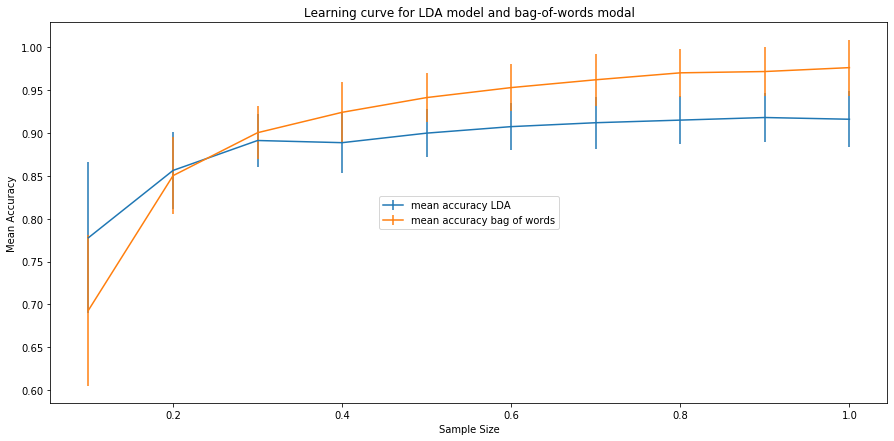

In [17]:

# calculating model statistics for both LDA and bag of word models
mean_acc_fold_lda, std_acc_lda = model_statics_calculation(accuracy_lda)
mean_acc_fold_bag, std_acc_bag = model_statics_calculation(accuracy_bag)
# the learning curve plot for both the model.
learning_curve(mean_acc_fold_lda, mean_acc_fold_bag, std_acc_lda, std_acc_bag)

# discussion on results

The learning curves for LDA model and bag-of-words model shows that both the model perform poorly with small data sets, where, the bag-of-words model performing much poor that LDA model, but as the size of training set increases, the bag-of-words model starts to perform better and continuourly increases its accuracy as the training size is increase. it achieves the maximum accuracy of close to 95% with full data avaialbe for training where as the LDA model is close to 90% at this trainign size.

The bag-of-words model performance is much lower than the LDA model, as for the bag-of-words model, which has a large numbe of features are not able to do optimal prediction when it seems smaller number of examples, but as it seems more and more number of examples, its performance improves. where as the LDA model with reduced dimenson words bettwe when it sees smaller number of examples and stagnates to a value when it seems larger number of examples.